<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/unsorted/improved_mr0_RARE_2D_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pypulseq &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

(RARE_2D_seq)=
# 2D RARE

echo time set to minTE [ms] 5.6
Timing check passed successfully
Calculating repetition 49 / 49 - done


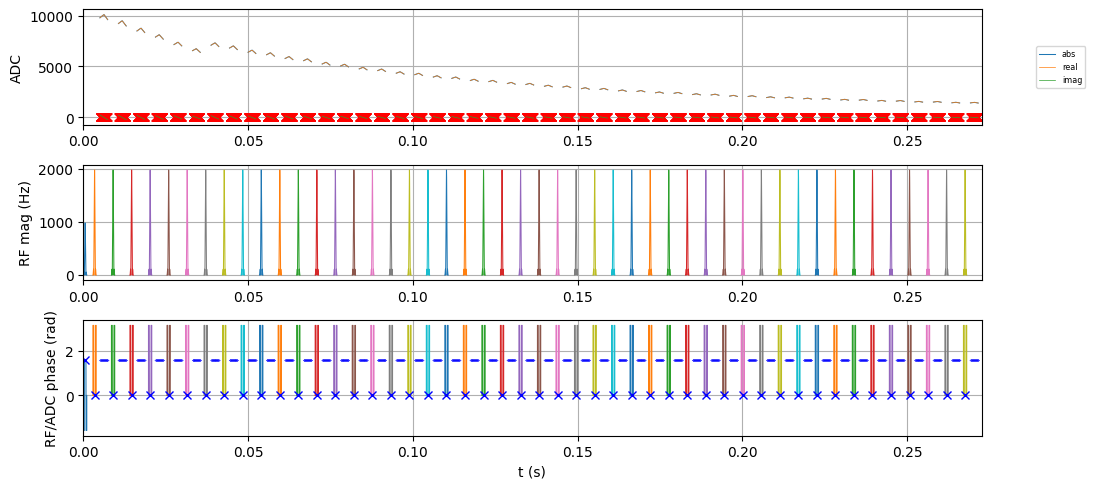

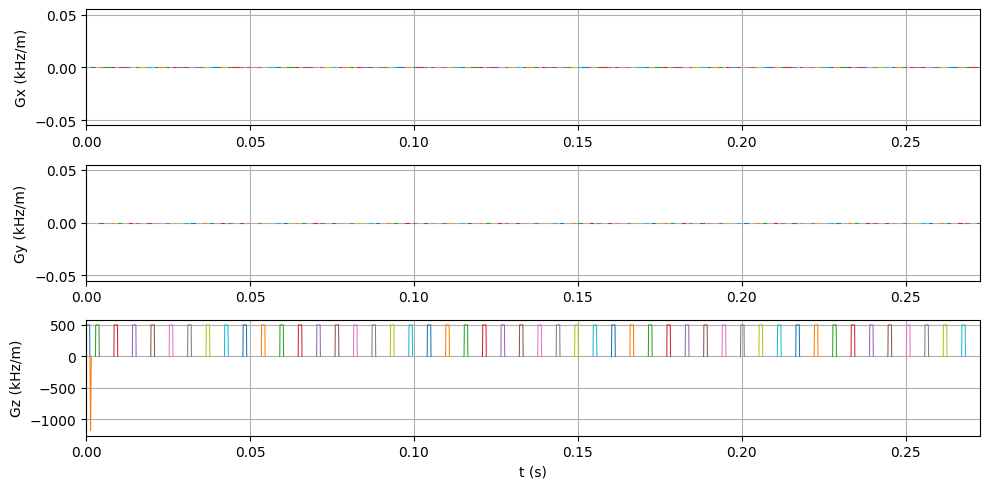

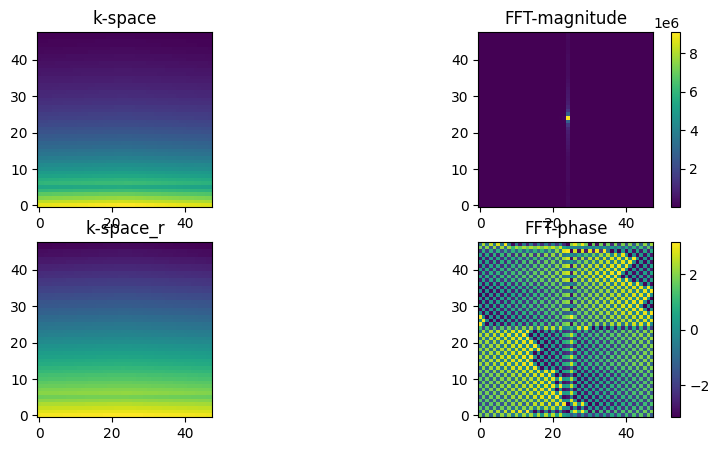

In [64]:
#@title RARE
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'RARE_2D'

# %% S1. SETUP sys
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6)

seq = pp.Sequence(system)
# Define FOV and resolution
fov = 200e-3
slice_thickness = 8e-3


base_resolution= 48 # @param {type: "slider", min: 2, max: 112,step:2}

Nread  = base_resolution  # frequency encoding steps/samples
Nphase = base_resolution  # phase encoding steps/samples

TE_ms=5 # @param {type: "slider", min: 0.0, max: 200.0}
TE=TE_ms*1e-3
TI_s=0 # @param {type: "slider", min: 0.0, max: 10.0, step: 0.1}
Excitation_FA=90 # @param {type: "slider", min: 10, max: 270}
Refocusing_FA=180 # @param {type: "slider", min: 10, max: 270}
r_spoil =2 # @param {type: "slider", min: 0, max: 3}
PE_grad_on=True # @param {type: "boolean"}
RO_grad_on=True # @param {type: "boolean"}

# Define rf events
rf1, gz1, gzr1 = pp.make_sinc_pulse(
    flip_angle=Excitation_FA * np.pi / 180, phase_offset=90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True)

rf2, gz2, _ = pp.make_sinc_pulse(
    flip_angle=Refocusing_FA* np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True)

dwell=50e-6

G_flag=(int(RO_grad_on),int(PE_grad_on))  # gradient flag (read,PE), if (0,0) all gradients are 0, for (1,0) PE is off

# Define other gradients and ADC events
gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov*G_flag[0], flat_time=Nread*dwell, system=system)
adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=90 * np.pi / 180, delay=gx.rise_time, system=system)
gx_pre0 = pp.make_trapezoid(channel='x', area=+((1.0 + r_spoil) * gx.area / 2) , duration=1.5e-3, system=system)
gx_prewinder = pp.make_trapezoid(channel='x', area=+(r_spoil * gx.area / 2 ), duration=1e-3, system=system)
gp = pp.make_trapezoid(channel='y', area=0 / fov, duration=1e-3, system=system)
rf_prep = pp.make_block_pulse(flip_angle=180 * np.pi / 180, duration=1e-3, system=system)


# FLAIR
if TI_s>0:
  seq.add_block(rf_prep)
  seq.add_block(pp.make_delay(TI_s))
  seq.add_block(gx_pre0)

seq.add_block(rf1,gz1)
seq.add_block(gx_pre0,gzr1)

# the minimal TE is given by one full period form ref pulse to ref pulse, thus rf2+gx+2*gp
minTE2=(pp.calc_duration(rf2) +pp.calc_duration(gx) + 2*pp.calc_duration(gp))/2
minTE2=round(minTE2/10e-5)*10e-5
# to realize longer TE,  we introduce a TEdelay that is added before and afetr the encoding period
TEd=round(max(0, (TE/2-minTE2))/10e-5)*10e-5  # round to raster time
if TEd==0:
  print('echo time set to minTE [ms]', 2*(minTE2 +TEd)*1000)
else:
  print(' TE [ms]', 2*(minTE2 +TEd)*1000)

# last timing step is to add TE/2 also between excitation and first ref pulse
# from pulse top to pulse top we have already played out one full rf and gx_pre0, thus we substract these from TE/2
seq.add_block(pp.make_delay((minTE2 +TEd ) - pp.calc_duration(rf1)-pp.calc_duration(gx_pre0)))

for ii in range(-Nphase // 2, Nphase // 2):  # e.g. -64:63
    gp  = pp.make_trapezoid(channel='y', area=+ii / fov*G_flag[1], duration=1e-3, system=system)
    gp_ = pp.make_trapezoid(channel='y', area=-ii / fov*G_flag[1], duration=1e-3, system=system)

    seq.add_block(rf2,gz2)
    seq.add_block(pp.make_delay(TEd)) # TE delay
    seq.add_block(gx_prewinder, gp)
    seq.add_block(adc, gx)
    seq.add_block(gx_prewinder, gp_)
    seq.add_block(pp.make_delay(TEd)) # TE delay

# %% S2. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]


# %% S3 quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)
#seq.plot(plot_now=False,time_range=(0,2.5*TE))
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
# Get figure handles
fig_handles = plt.get_fignums()

# Iterate and save each figure
for fig_num in fig_handles:
    plt.figure(fig_num)
    plt.savefig(f'TSE_{fig_num}.png', format='png')

plt.show()

# %% S4: MR IMAGE RECON of signal ::: #####################################
kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
# fftshift,FFT,fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(221)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(223)
plt.title('k-space_r')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(222)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(224)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()
